# PhysioNet EEG-ARNN Training Pipeline

This notebook implements the complete training pipeline with:
- Subject-specific 3-fold cross-validation
- Edge Selection (ES) and Aggregation Selection (AS)
- Experiments with different k values (10, 15, 20, 25)
- Comprehensive results and visualizations

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import mne

# IMPORTANT: Force reload train_utils to get latest fixes
import importlib
import train_utils
importlib.reload(train_utils)

from models import EEGARNN, ChannelSelector
from train_utils import (
    load_preprocessed_data, filter_classes, normalize_data,
    cross_validate_subject, EEGDataset
)

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Verify the fix is loaded
print("\n" + "="*80)
print("VERIFICATION: Checking if train_utils.py fix is loaded...")
print("="*80)
import inspect
source = inspect.getsource(load_preprocessed_data)
if 'events_from_annotations' in source:
    print("✓ GOOD: train_utils.py has the annotations fix!")
else:
    print("✗ ERROR: train_utils.py is still using old code!")
    print("  → Please restart Jupyter kernel: Kernel → Restart Kernel")
    print("  → Then re-run all cells from the top")
print("="*80)

C:\Users\SHIVAPREETHAM ROHITH\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu

VERIFICATION: Checking if train_utils.py fix is loaded...
✓ GOOD: train_utils.py has the annotations fix!


## Configuration

In [2]:

EXPERIMENT_CONFIG = {
    'data': {
        'preprocessed_dir': Path('data/physionet/derived/preprocessed'),
        'index_file': Path('data/physionet/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],  # T1, T2 (or [1, 2, 3, 4] for 4-class)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 10,  # Reduced from 100 to 50
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2,
        'patience': 8
    },
    'gating': {
        'enabled': True,
        'l1_lambda': 1e-3,
        'gate_init': 0.9
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25, 'all'],  # Different k to test
        'methods': ['ES', 'AS']  # Edge Selection, Aggregation Selection
    },
    'output': {
        'results_dir': Path('results'),
        'models_dir': Path('saved_models'),
        'gated_results_file': 'trial4_gated_subject_results.csv',
        'gate_importance_file': 'trial4_gate_importances.csv',
        'channel_selection_results_file': 'trial4_channel_selection_results.csv',
        'retrain_results_file': 'trial4_retrain_results.csv',
        'baseline_results_file': 'subject_results.csv',
        'comparison_file': 'trial4_gated_vs_baseline.csv',
        'results_summary_figure': 'trial4_gated_results_summary.png',
        'adjacency_prefix': 'trial4_adjacency'
    },
    'max_subjects': 5  # Train on only 5 subjects
}

EXPERIMENT_CONFIG['output']['results_dir'].mkdir(exist_ok=True)
EXPERIMENT_CONFIG['output']['models_dir'].mkdir(exist_ok=True)

print('Experiment Configuration:')
print(json.dumps(EXPERIMENT_CONFIG, indent=2, default=str))


Experiment Configuration:
{
  "data": {
    "preprocessed_dir": "data\\physionet\\derived\\preprocessed",
    "index_file": "data\\physionet\\derived\\physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "model": {
    "hidden_dim": 40,
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2,
    "patience": 8
  },
  "gating": {
    "enabled": true,
    "l1_lambda": 0.001,
    "gate_init": 0.9
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25,
      "all"
    ],
    "methods": [
      "ES",
      "AS"
    ]
  },
  "output": {
    "results_dir": "results",
    "models_dir": "saved_models",
    "gated_results_file": "trial4_gated_subject_results.csv",
    "gate_importance_file": "trial4_gate_importances.csv",
    "channel_selection_results_file": "trial4_channel_selection_results.csv",
    "retrain_results_

## Gated Model Utilities

Learnable channel gates with L1 sparsity regularization for trial 4 experiments.

In [3]:

# Utilities for models with learnable channel gates
from copy import deepcopy
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def _init_gate_logits(num_channels: int, gate_init: float) -> torch.Tensor:
    init = torch.full((num_channels,), float(gate_init), dtype=torch.float32)
    init = torch.clamp(init, 1e-4, 1 - 1e-4)
    return torch.logit(init)


class GatedEEGARNN(EEGARNN):
    '''EEG-ARNN variant with learnable channel gates.'''
    def __init__(self, num_channels=64, num_timepoints=512, num_classes=4, hidden_dim=40, gate_init=0.9):
        super().__init__(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=hidden_dim
        )
        gate_logits = _init_gate_logits(num_channels, gate_init)
        self.gate_logits = nn.Parameter(gate_logits)
        self.latest_gates = None

    def get_gate_values(self):
        return torch.sigmoid(self.gate_logits)

    def forward(self, x):
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        x = x * gate_values.view(1, 1, -1, 1)
        return super().forward(x)


def train_epoch_with_gates(model, dataloader, criterion, optimizer, device, l1_lambda=0.0):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    gate_penalties, gate_means = [], []

    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)

        if l1_lambda > 0 and hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            gate_penalty = l1_lambda * gate_values.abs().mean()
            loss = loss + gate_penalty
            gate_penalties.append(gate_penalty.item())
            gate_means.append(gate_values.mean().item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(len(dataloader), 1)
    accuracy = accuracy_score(all_labels, all_preds)
    avg_penalty = float(np.mean(gate_penalties)) if gate_penalties else 0.0
    avg_gate_mean = float(np.mean(gate_means)) if gate_means else 0.0

    return avg_loss, accuracy, avg_penalty, avg_gate_mean


def train_model_with_gates(model, train_loader, val_loader, device, epochs=100, lr=0.001,
                           patience=10, l1_lambda=0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'gate_penalty': [],
        'gate_mean': []
    }

    best_val_acc = 0.0
    best_model_state = deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc, gate_penalty, gate_mean = train_epoch_with_gates(
            model, train_loader, criterion, optimizer, device, l1_lambda=l1_lambda
        )
        val_loss, val_acc, _, _ = train_utils.evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['gate_penalty'].append(gate_penalty)
        history['gate_mean'].append(gate_mean)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"    Early stopping at epoch {epoch + 1}")
            break

    return history, best_model_state


def cross_validate_subject_with_gates(
    data, labels, num_channels, num_timepoints, num_classes,
    device, n_splits=3, epochs=30, lr=0.001, batch_size=64, patience=8,
    l1_lambda=0.0, gate_init=0.9
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    adjacency_matrices = []
    gate_values_per_fold = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"  Fold {fold + 1}/{n_splits}", end=" ", flush=True)

        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        X_train = train_utils.normalize_data(X_train)
        X_val = train_utils.normalize_data(X_val)

        train_dataset = train_utils.EEGDataset(X_train, y_train)
        val_dataset = train_utils.EEGDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        model = GatedEEGARNN(
            num_channels=num_channels,
            num_timepoints=num_timepoints,
            num_classes=num_classes,
            hidden_dim=EXPERIMENT_CONFIG['model']['hidden_dim'],
            gate_init=gate_init
        ).to(device)

        history, best_state = train_model_with_gates(
            model, train_loader, val_loader, device,
            epochs=epochs, lr=lr, patience=patience, l1_lambda=l1_lambda
        )

        model.load_state_dict(best_state)
        _, val_acc, val_preds, val_labels = train_utils.evaluate(
            model, val_loader, nn.CrossEntropyLoss(), device
        )

        adj_matrix = model.get_final_adjacency_matrix()
        adjacency_matrices.append(adj_matrix)

        gate_values = model.get_gate_values().detach().cpu().numpy()
        gate_values_per_fold.append(gate_values)

        fold_results.append({
            'fold': fold,
            'val_acc': val_acc,
            'history': history,
            'gate_mean': float(gate_values.mean()),
            'gate_std': float(gate_values.std()),
            'preds': val_preds,
            'labels': val_labels
        })

        print(f"-> Acc: {val_acc:.3f}")

    avg_adjacency = np.mean(adjacency_matrices, axis=0)
    avg_gate_values = np.mean(np.stack(gate_values_per_fold, axis=0), axis=0)

    return {
        'fold_results': fold_results,
        'avg_accuracy': np.mean([r['val_acc'] for r in fold_results]),
        'std_accuracy': np.std([r['val_acc'] for r in fold_results]),
        'adjacency_matrix': avg_adjacency,
        'gate_values_per_fold': gate_values_per_fold,
        'avg_gate_values': avg_gate_values
    }


## Load Preprocessed Data Index

In [4]:
index_df = pd.read_csv(EXPERIMENT_CONFIG['data']['index_file'])
success_df = index_df[index_df['status'] == 'success'].copy()

print(f"Total preprocessed runs: {len(index_df)}")
print(f"Successful runs: {len(success_df)}")
print(f"\nSubjects available: {success_df['subject'].nunique()}")
print(f"\nRuns per category:")
print(success_df.groupby('category')['run'].count())

success_df.head()

Total preprocessed runs: 669
Successful runs: 669

Subjects available: 51

Runs per category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:38.863386,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes open,NaN
1,S001,R02,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:39.482853,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:39.869856,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:40.658595,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-23T17:52:41.551311,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both feet (executed),NaN


## Subject Selection

Select subjects for training. For motor imagery, we focus on motor execution and motor imagery runs.

In [5]:
# Filter motor-related runs (execution and imagery)
motor_runs = success_df[success_df['category'].isin(['motor_execution', 'motor_imagery'])].copy()

# Count runs per subject
subject_counts = motor_runs.groupby('subject').size().reset_index(name='num_runs')
subject_counts = subject_counts[subject_counts['num_runs'] >= 10]  # At least 10 runs

selected_subjects = subject_counts['subject'].tolist()

print(f"Subjects with >=10 motor runs: {len(selected_subjects)}")
print(f"\nFirst 10 subjects: {selected_subjects[:10]}")

# Limit to max_subjects for this experiment
max_subjects = EXPERIMENT_CONFIG.get('max_subjects', len(selected_subjects))
selected_subjects = selected_subjects[:max_subjects]

print(f"\nWill train on {len(selected_subjects)} subjects")
print(f"Selected subjects: {selected_subjects}")

Subjects with >=10 motor runs: 49

First 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']

Will train on 5 subjects
Selected subjects: ['S001', 'S002', 'S005', 'S006', 'S007']


## Helper Functions

In [6]:
def load_subject_data(subject_id, preprocessed_dir, motor_runs_df, config):
    """
    Load all motor runs for a subject and concatenate
    
    Returns
    -------
    data : np.ndarray or None
        (n_trials, n_channels, n_timepoints)
    labels : np.ndarray or None
        (n_trials,)
    channel_names : list
        List of channel names
    """
    subject_runs = motor_runs_df[motor_runs_df['subject'] == subject_id]
    
    all_data = []
    all_labels = []
    channel_names = None
    
    for _, run_info in subject_runs.iterrows():
        fif_path = Path(run_info['path'])
        
        if not fif_path.exists():
            continue
        
        try:
            data, labels = load_preprocessed_data(
                fif_path,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline']
            )
            
            if data is not None and len(data) > 0:
                all_data.append(data)
                all_labels.append(labels)
                
                if channel_names is None:
                    raw = mne.io.read_raw_fif(fif_path, preload=False, verbose='ERROR')
                    channel_names = raw.ch_names
                    
        except Exception as e:
            print(f"Error loading {fif_path.name}: {e}")
            continue
    
    if len(all_data) == 0:
        return None, None, None
    
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Filter to selected classes
    all_data, all_labels = filter_classes(
        all_data, all_labels, config['data']['selected_classes']
    )
    
    return all_data, all_labels, channel_names

## Main Training Loop

Train subject-specific models with 3-fold cross-validation

In [7]:

all_results = []
gate_analysis_records = []

for subject_id in tqdm(selected_subjects, desc="Training subjects (gated)"):
    print(f"{'='*80}")
    print(f"Training subject: {subject_id}")
    print(f"{'='*80}")

    data, labels, channel_names = load_subject_data(
        subject_id,
        EXPERIMENT_CONFIG['data']['preprocessed_dir'],
        motor_runs,
        EXPERIMENT_CONFIG
    )

    if data is None or len(data) < 30:
        print(f"Skipping {subject_id}: insufficient data")
        continue

    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    print(f"Channels: {len(channel_names)}")

    num_channels = data.shape[1]
    num_timepoints = data.shape[2]
    num_classes = len(np.unique(labels))

    model_cfg = EXPERIMENT_CONFIG['model']
    gating_cfg = EXPERIMENT_CONFIG.get('gating', {})

    cv_results = cross_validate_subject_with_gates(
        data, labels,
        num_channels=num_channels,
        num_timepoints=num_timepoints,
        num_classes=num_classes,
        device=device,
        n_splits=model_cfg['n_folds'],
        epochs=model_cfg['epochs'],
        lr=model_cfg['learning_rate'],
        batch_size=model_cfg['batch_size'],
        patience=model_cfg.get('patience', 8),
        l1_lambda=gating_cfg.get('l1_lambda', 0.0),
        gate_init=gating_cfg.get('gate_init', 0.9)
    )

    gate_values = cv_results['avg_gate_values']
    gate_stats = {
        'mean': float(gate_values.mean()),
        'std': float(gate_values.std()),
        'min': float(gate_values.min()),
        'max': float(gate_values.max())
    }

    print(f"Gated accuracy: {cv_results['avg_accuracy']:.4f} +/- {cv_results['std_accuracy']:.4f}")
    print(f"Gate mean: {gate_stats['mean']:.4f} | min: {gate_stats['min']:.4f} | max: {gate_stats['max']:.4f}")

    result = {
        'subject': subject_id,
        'num_trials': int(len(data)),
        'num_channels': int(num_channels),
        'num_timepoints': int(num_timepoints),
        'num_classes': int(num_classes),
        'gated_acc': float(cv_results['avg_accuracy']),
        'gated_std': float(cv_results['std_accuracy']),
        'adjacency_matrix': cv_results['adjacency_matrix'],
        'channel_names': channel_names,
        'gate_values': gate_values.tolist(),
        'gate_values_per_fold': [gv.tolist() for gv in cv_results['gate_values_per_fold']],
        'gate_mean': gate_stats['mean'],
        'gate_std': gate_stats['std'],
        'gate_min': gate_stats['min'],
        'gate_max': gate_stats['max'],
        'fold_results': cv_results['fold_results']
    }

    all_results.append(result)

    for channel_name, gate_value in zip(channel_names, gate_values):
        gate_analysis_records.append({
            'subject': subject_id,
            'channel': channel_name,
            'gate_value': float(gate_value)
        })

print(f"{'='*80}")
print(f"Training complete for {len(all_results)} subjects")
print(f"{'='*80}")


Training subjects (gated):   0%|          | 0/5 [00:00<?, ?it/s]

Training subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77], dtype=int64))
Channels: 64
  Fold 1/2     Early stopping at epoch 10
-> Acc: 0.767
  Fold 2/2 

Training subjects (gated):  20%|██        | 1/5 [37:12<2:28:51, 2232.95s/it]

-> Acc: 0.739
Gated accuracy: 0.7532 +/- 0.0141
Gate mean: 0.9000 | min: 0.8993 | max: 0.9009
Training subject: S002
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.802
  Fold 2/2 

Training subjects (gated):  40%|████      | 2/5 [1:08:56<1:41:57, 2039.30s/it]

-> Acc: 0.757
Gated accuracy: 0.7791 +/- 0.0226
Gate mean: 0.8999 | min: 0.8992 | max: 0.9007
Training subject: S005
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.738
  Fold 2/2 

Training subjects (gated):  60%|██████    | 3/5 [1:42:36<1:07:41, 2030.53s/it]

-> Acc: 0.762
Gated accuracy: 0.7500 +/- 0.0119
Gate mean: 0.9000 | min: 0.8986 | max: 0.9013
Training subject: S006
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.754
  Fold 2/2 

Training subjects (gated):  80%|████████  | 4/5 [2:14:00<32:52, 1972.70s/it]  

-> Acc: 0.746
Gated accuracy: 0.7500 +/- 0.0040
Gate mean: 0.8999 | min: 0.8992 | max: 0.9005
Training subject: S007
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84], dtype=int64))
Channels: 64
  Fold 1/2 -> Acc: 0.913
  Fold 2/2 

Training subjects (gated): 100%|██████████| 5/5 [3:25:13<00:00, 2462.71s/it]

-> Acc: 0.905
Gated accuracy: 0.9087 +/- 0.0040
Gate mean: 0.9000 | min: 0.8992 | max: 0.9007
Training complete for 5 subjects


## Channel Gate Analysis

Aggregate the learned gate strengths across subjects.

In [8]:

gate_importance_df = pd.DataFrame(gate_analysis_records)

if len(gate_importance_df) > 0:
    subject_gate_summary = gate_importance_df.groupby('subject')['gate_value'].agg(['mean', 'std', 'min', 'max']).reset_index()
    print('Per-subject gate statistics:')
    display(subject_gate_summary)

    channel_gate_summary = (
        gate_importance_df.groupby('channel')['gate_value']
        .agg(['mean', 'std'])
        .sort_values('mean', ascending=False)
    )
    print('Top channels by mean gate value:')
    display(channel_gate_summary.head(15))

    gate_importance_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gate_importance_file']
    channel_gate_summary.reset_index().to_csv(gate_importance_path, index=False)
    print(f"{'='*80}")
    print(f"Gate importance saved to: {gate_importance_path}")

    channel_gate_summary_df = channel_gate_summary.reset_index()
else:
    print('No gate values recorded. Ensure training ran successfully.')
    channel_gate_summary_df = pd.DataFrame()


Per-subject gate statistics:


,subject,mean,std,min,max
0,S001,0.899962,0.000402,0.899307,0.900853
1,S002,0.899903,0.000346,0.899153,0.900695
2,S005,0.900008,0.000616,0.898622,0.901283
3,S006,0.899902,0.000295,0.899187,0.900540
4,S007,0.899950,0.000413,0.899168,0.900732


Top channels by mean gate value:


,mean,std
channel,,
C4,0.900272,0.000323
Po3,0.900221,0.000571
Cp2,0.900204,0.000694
Cpz,0.900192,0.000469
Cp4,0.900141,0.000410
Cp3,0.900140,0.000580
Fp1,0.900138,0.000478
C2,0.900137,0.000178
Fc1,0.900135,0.000440


Gate importance saved to: results\trial4_gate_importances.csv


## Channel Selection Experiments

Test different k values with Edge Selection and Aggregation Selection

In [ ]:
channel_selection_results = []

if len(all_results) > 0:
    for result in tqdm(all_results, desc="Channel selection experiments"):
        subject_id = result['subject']
        adj_matrix = result['adjacency_matrix']
        channel_names = result['channel_names']
        
        print(f"\nProcessing channel selection for {subject_id}")
        
        selector = ChannelSelector(adj_matrix, channel_names)
        
        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            print(f"  Method: {method}")
            
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    k_val = result['num_channels']
                    selected_channels = channel_names
                else:
                    k_val = min(k, result['num_channels'])  # Don't exceed available channels
                    
                    if method == 'ES':
                        selected_channels, _ = selector.edge_selection(k_val)
                    else:  # AS
                        selected_channels, _ = selector.aggregation_selection(k_val)
                
                print(f"    k={k_val}: {len(selected_channels)} channels selected")
                
                channel_selection_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy_full': result['gated_acc']
                })

    channel_selection_df = pd.DataFrame(channel_selection_results)
    print(f"\nChannel selection results: {len(channel_selection_df)} experiments")
    display(channel_selection_df.head(10))
else:
    channel_selection_df = pd.DataFrame()
    print("\nNo results available for channel selection experiments.")

Channel selection experiments:   0%|          | 0/5 [00:00<?, ?it/s]


Processing channel selection for S001
  Method: ES
    k=10: 18 channels selected
    k=15: 25 channels selected
    k=20: 28 channels selected
    k=25: 33 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S002
  Method: ES
    k=10: 16 channels selected
    k=15: 24 channels selected
    k=20: 29 channels selected
    k=25: 36 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S005
  Method: ES
    k=10: 15 channels selected
    k=15: 23 channels selected
    k=20: 29 channels selected


Channel selection experiments: 100%|██████████| 5/5 [00:00<00:00, 40.04it/s]

    k=25: 34 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S006
  Method: ES
    k=10: 16 channels selected
    k=15: 23 channels selected
    k=20: 29 channels selected
    k=25: 33 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Processing channel selection for S007
  Method: ES
    k=10: 15 channels selected
    k=15: 24 channels selected
    k=20: 30 channels selected
    k=25: 35 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected

Channel selection r

,subject,method,k,num_selected,selected_channels,accuracy_full
0,S001,ES,10,18,"[C3, C2, C4, Cp5, Af3, Afz, F5, F1, F2, F6, T7...",0.753186
1,S001,ES,15,25,"[Fc3, Fc4, C3, C2, C4, Cp5, Cp1, Af3, Afz, Af8...",0.753186
2,S001,ES,20,28,"[Fc3, Fc4, C3, C2, C4, Cp5, Cp1, Af3, Afz, Af8...",0.753186
3,S001,ES,25,33,"[Fc3, Fcz, Fc4, C3, C2, C4, Cp5, Cp1, Fpz, Fp2...",0.753186
4,S001,ES,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.753186
5,S001,AS,10,10,"[Fcz, C5, C2, Ft7, T7, Tp7, Tp8, P1, Po4, Po8]",0.753186
6,S001,AS,15,15,"[Fcz, Fc6, C5, C3, C2, Afz, Af8, F6, Ft7, T7, ...",0.753186
7,S001,AS,20,20,"[Fcz, Fc4, Fc6, C5, C3, C2, C4, Afz, Af8, Fz, ...",0.753186
8,S001,AS,25,25,"[Fcz, Fc4, Fc6, C5, C3, Cz, C2, C4, Afz, Af8, ...",0.753186
9,S001,AS,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...",0.753186


In [10]:

from train_utils import retrain_with_selected_channels

# Store all retraining results
retrain_results = []

if len(all_results) > 0:
    subject_data_cache = {}

    for result in all_results:
        subject_id = result['subject']
        print(f"Loading data for {subject_id}")

        data, labels, channel_names = load_subject_data(
            subject_id,
            EXPERIMENT_CONFIG['data']['preprocessed_dir'],
            motor_runs,
            EXPERIMENT_CONFIG
        )

        if data is None:
            continue

        subject_data_cache[subject_id] = {
            'data': data,
            'labels': labels,
            'channel_names': channel_names
        }

    print(f"{'='*80}")
    print('RETRAINING WITH SELECTED CHANNELS')
    print(f"{'='*80}")

    for result in tqdm(all_results, desc='Retraining subjects'):
        subject_id = result['subject']

        if subject_id not in subject_data_cache:
            continue

        cache = subject_data_cache[subject_id]
        data = cache['data']
        labels = cache['labels']
        channel_names = cache['channel_names']

        print(f"Retraining {subject_id}")

        selector = ChannelSelector(result['adjacency_matrix'], channel_names)

        for method in EXPERIMENT_CONFIG['channel_selection']['methods']:
            for k in EXPERIMENT_CONFIG['channel_selection']['k_values']:
                if k == 'all':
                    continue

                k_val = min(k, result['num_channels'])

                if method == 'ES':
                    selected_channels, selected_indices = selector.edge_selection(k_val)
                else:
                    selected_channels, selected_indices = selector.aggregation_selection(k_val)

                print(f"  {method} k={k_val}: Retraining with {len(selected_channels)} channels...")

                retrain_res = retrain_with_selected_channels(
                    data, labels,
                    selected_channel_indices=selected_indices,
                    num_timepoints=result['num_timepoints'],
                    num_classes=result['num_classes'],
                    device=device,
                    n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
                    epochs=EXPERIMENT_CONFIG['model']['epochs'],
                    lr=EXPERIMENT_CONFIG['model']['learning_rate']
                )

                acc_drop = result['gated_acc'] - retrain_res['avg_accuracy']

                print(f"    Accuracy: {retrain_res['avg_accuracy']:.4f} +/- {retrain_res['std_accuracy']:.4f}")
                print(f"    Drop from full: {acc_drop:.4f} ({acc_drop/result['gated_acc']*100:.1f}%)")

                retrain_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_channels_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy': retrain_res['avg_accuracy'],
                    'std': retrain_res['std_accuracy'],
                    'full_channels_acc': result['gated_acc'],
                    'accuracy_drop': acc_drop,
                    'accuracy_drop_pct': acc_drop / result['gated_acc'] * 100
                })

    retrain_df = pd.DataFrame(retrain_results)
    print(f"{'='*80}")
    print(f'Retraining complete: {len(retrain_df)} experiments')
    print(f"{'='*80}")

    retrain_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['retrain_results_file']
    retrain_df.to_csv(retrain_path, index=False)
    print(f"Retrain results saved to: {retrain_path}")
else:
    retrain_df = pd.DataFrame()
    print('No results to retrain. Please run training first.')


Loading data for S001
Loading data for S002
Loading data for S005
Loading data for S006
Loading data for S007
RETRAINING WITH SELECTED CHANNELS


Retraining subjects:   0%|          | 0/5 [00:00<?, ?it/s]

Retraining S001
  ES k=10: Retraining with 18 channels...
    Accuracy: 0.7275 +/- 0.0551
    Drop from full: 0.0257 (3.4%)
  ES k=15: Retraining with 25 channels...
    Accuracy: 0.7313 +/- 0.0704
    Drop from full: 0.0219 (2.9%)
  ES k=20: Retraining with 28 channels...
    Accuracy: 0.5488 +/- 0.2184
    Drop from full: 0.2043 (27.1%)
  ES k=25: Retraining with 33 channels...
    Accuracy: 0.7402 +/- 0.0098
    Drop from full: 0.0130 (1.7%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.7790 +/- 0.0486
    Drop from full: -0.0258 (-3.4%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.6537 +/- 0.0072
    Drop from full: 0.0995 (13.2%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.5018 +/- 0.0931
    Drop from full: 0.2514 (33.4%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  20%|██        | 1/5 [1:00:02<4:00:08, 3602.22s/it]

    Accuracy: 0.5448 +/- 0.1535
    Drop from full: 0.2084 (27.7%)
Retraining S002
  ES k=10: Retraining with 16 channels...
    Accuracy: 0.5799 +/- 0.0494
    Drop from full: 0.1993 (25.6%)
  ES k=15: Retraining with 24 channels...
    Accuracy: 0.5670 +/- 0.0192
    Drop from full: 0.2121 (27.2%)
  ES k=20: Retraining with 29 channels...
    Accuracy: 0.6405 +/- 0.0405
    Drop from full: 0.1386 (17.8%)
  ES k=25: Retraining with 36 channels...
    Accuracy: 0.5891 +/- 0.0805
    Drop from full: 0.1900 (24.4%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6362 +/- 0.0275
    Drop from full: 0.1429 (18.3%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.6272 +/- 0.1055
    Drop from full: 0.1519 (19.5%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.6623 +/- 0.0015
    Drop from full: 0.1168 (15.0%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  40%|████      | 2/5 [2:03:04<3:05:25, 3708.41s/it]

    Accuracy: 0.6405 +/- 0.0492
    Drop from full: 0.1386 (17.8%)
Retraining S005
  ES k=10: Retraining with 15 channels...
    Accuracy: 0.5714 +/- 0.1746
    Drop from full: 0.1786 (23.8%)
  ES k=15: Retraining with 23 channels...
    Accuracy: 0.7143 +/- 0.0556
    Drop from full: 0.0357 (4.8%)
  ES k=20: Retraining with 29 channels...
    Accuracy: 0.7698 +/- 0.0079
    Drop from full: -0.0198 (-2.6%)
  ES k=25: Retraining with 34 channels...
    Accuracy: 0.5556 +/- 0.0635
    Drop from full: 0.1944 (25.9%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6151 +/- 0.1230
    Drop from full: 0.1349 (18.0%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.6905 +/- 0.0556
    Drop from full: 0.0595 (7.9%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.7937 +/- 0.0873
    Drop from full: -0.0437 (-5.8%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  60%|██████    | 3/5 [3:09:49<2:08:06, 3843.46s/it]

    Accuracy: 0.6825 +/- 0.0000
    Drop from full: 0.0675 (9.0%)
Retraining S006
  ES k=10: Retraining with 16 channels...
    Accuracy: 0.6270 +/- 0.0000
    Drop from full: 0.1230 (16.4%)
  ES k=15: Retraining with 23 channels...
    Accuracy: 0.6627 +/- 0.0198
    Drop from full: 0.0873 (11.6%)
  ES k=20: Retraining with 29 channels...
    Accuracy: 0.6429 +/- 0.0079
    Drop from full: 0.1071 (14.3%)
  ES k=25: Retraining with 33 channels...
    Accuracy: 0.6389 +/- 0.0198
    Drop from full: 0.1111 (14.8%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.6667 +/- 0.0556
    Drop from full: 0.0833 (11.1%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.6667 +/- 0.0556
    Drop from full: 0.0833 (11.1%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.6627 +/- 0.0675
    Drop from full: 0.0873 (11.6%)
  AS k=25: Retraining with 25 channels...


Retraining subjects:  80%|████████  | 4/5 [6:19:14<1:53:32, 6812.94s/it]

    Accuracy: 0.5833 +/- 0.0119
    Drop from full: 0.1667 (22.2%)
Retraining S007
  ES k=10: Retraining with 15 channels...
    Accuracy: 0.8214 +/- 0.0040
    Drop from full: 0.0873 (9.6%)
  ES k=15: Retraining with 24 channels...
    Accuracy: 0.8373 +/- 0.0437
    Drop from full: 0.0714 (7.9%)
  ES k=20: Retraining with 30 channels...
    Accuracy: 0.8452 +/- 0.0278
    Drop from full: 0.0635 (7.0%)
  ES k=25: Retraining with 35 channels...
    Accuracy: 0.8016 +/- 0.0952
    Drop from full: 0.1071 (11.8%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.8492 +/- 0.0159
    Drop from full: 0.0595 (6.6%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.7540 +/- 0.0238
    Drop from full: 0.1548 (17.0%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.9008 +/- 0.0040
    Drop from full: 0.0079 (0.9%)
  AS k=25: Retraining with 25 channels...


Retraining subjects: 100%|██████████| 5/5 [7:34:05<00:00, 5449.15s/it]  

    Accuracy: 0.8730 +/- 0.0079
    Drop from full: 0.0357 (3.9%)
Retraining complete: 40 experiments
Retrain results saved to: results\trial4_retrain_results.csv


## Retrain with Selected Channels

Now retrain the model using ONLY the selected channels and compare accuracy

## Results Summary

In [11]:

results_df = pd.DataFrame(all_results)

print("=" * 80)
print("OVERALL RESULTS SUMMARY (Gated Model)")
print("=" * 80)
print(f"Subjects trained: {len(results_df)}")

if len(results_df) > 0:
    print(f"Mean gated accuracy: {results_df['gated_acc'].mean():.4f} +/- {results_df['gated_acc'].std():.4f}")
    print(f"Best subject: {results_df.loc[results_df['gated_acc'].idxmax(), 'subject']} ({results_df['gated_acc'].max():.4f})")
    print(f"Worst subject: {results_df.loc[results_df['gated_acc'].idxmin(), 'subject']} ({results_df['gated_acc'].min():.4f})")

    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gated_results_file']
    cols_to_save = ['subject', 'num_trials', 'num_channels', 'gated_acc', 'gated_std', 'gate_mean', 'gate_std', 'gate_min', 'gate_max']
    results_df[cols_to_save].to_csv(results_path, index=False)
    print(f"Results saved to: {results_path}")

    display(results_df[cols_to_save].head(10))
else:
    print("No subjects were successfully trained. Check the data loading and preprocessing steps.")

results_df


OVERALL RESULTS SUMMARY (Gated Model)
Subjects trained: 5
Mean gated accuracy: 0.7882 +/- 0.0685
Best subject: S007 (0.9087)
Worst subject: S005 (0.7500)
Results saved to: results\trial4_gated_subject_results.csv


,subject,num_trials,num_channels,gated_acc,gated_std,gate_mean,gate_std,gate_min,gate_max
0,S001,231,64,0.753186,0.014055,0.899962,0.000399,0.899307,0.900853
1,S002,231,64,0.779123,0.022601,0.899903,0.000344,0.899153,0.900695
2,S005,252,64,0.750000,0.011905,0.900008,0.000612,0.898622,0.901283
3,S006,252,64,0.750000,0.003968,0.899902,0.000293,0.899187,0.900540
4,S007,252,64,0.908730,0.003968,0.899950,0.000409,0.899168,0.900732


,subject,num_trials,num_channels,num_timepoints,num_classes,gated_acc,gated_std,adjacency_matrix,channel_names,gate_values,gate_values_per_fold,gate_mean,gate_std,gate_min,gate_max,fold_results
0,S001,231,64,769,2,0.753186,0.014055,"[[0.47549897, 0.4720344, 0.5040588, 0.52701914...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.9004557728767395, 0.90038001537323, 0.89997...","[[0.8997893333435059, 0.8999308943748474, 0.90...",0.899962,0.000399,0.899307,0.900853,"[{'fold': 0, 'val_acc': 0.7672413793103449, 'h..."
1,S002,231,64,769,2,0.779123,0.022601,"[[0.47365597, 0.5195899, 0.4854976, 0.49631286...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8996865153312683, 0.8999582529067993, 0.900...","[[0.8994457721710205, 0.9000767469406128, 0.90...",0.899903,0.000344,0.899153,0.900695,"[{'fold': 0, 'val_acc': 0.8017241379310345, 'h..."
2,S005,252,64,769,2,0.750000,0.011905,"[[0.5334298, 0.48782122, 0.5003617, 0.48067665...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.9008309841156006, 0.9001386165618896, 0.899...","[[0.9008285403251648, 0.8997056484222412, 0.89...",0.900008,0.000612,0.898622,0.901283,"[{'fold': 0, 'val_acc': 0.7380952380952381, 'h..."
3,S006,252,64,769,2,0.750000,0.003968,"[[0.4963833, 0.51284, 0.5208595, 0.4871856, 0....","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8993446826934814, 0.8995814323425293, 0.899...","[[0.899187445640564, 0.899351954460144, 0.8993...",0.899902,0.000293,0.899187,0.900540,"[{'fold': 0, 'val_acc': 0.753968253968254, 'hi..."
4,S007,252,64,769,2,0.908730,0.003968,"[[0.52944624, 0.51549906, 0.50612235, 0.503199...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0.8996691107749939, 0.9005360007286072, 0.900...","[[0.8996447324752808, 0.9006174802780151, 0.90...",0.899950,0.000409,0.899168,0.900732,"[{'fold': 0, 'val_acc': 0.9126984126984127, 'h..."


## Visualizations

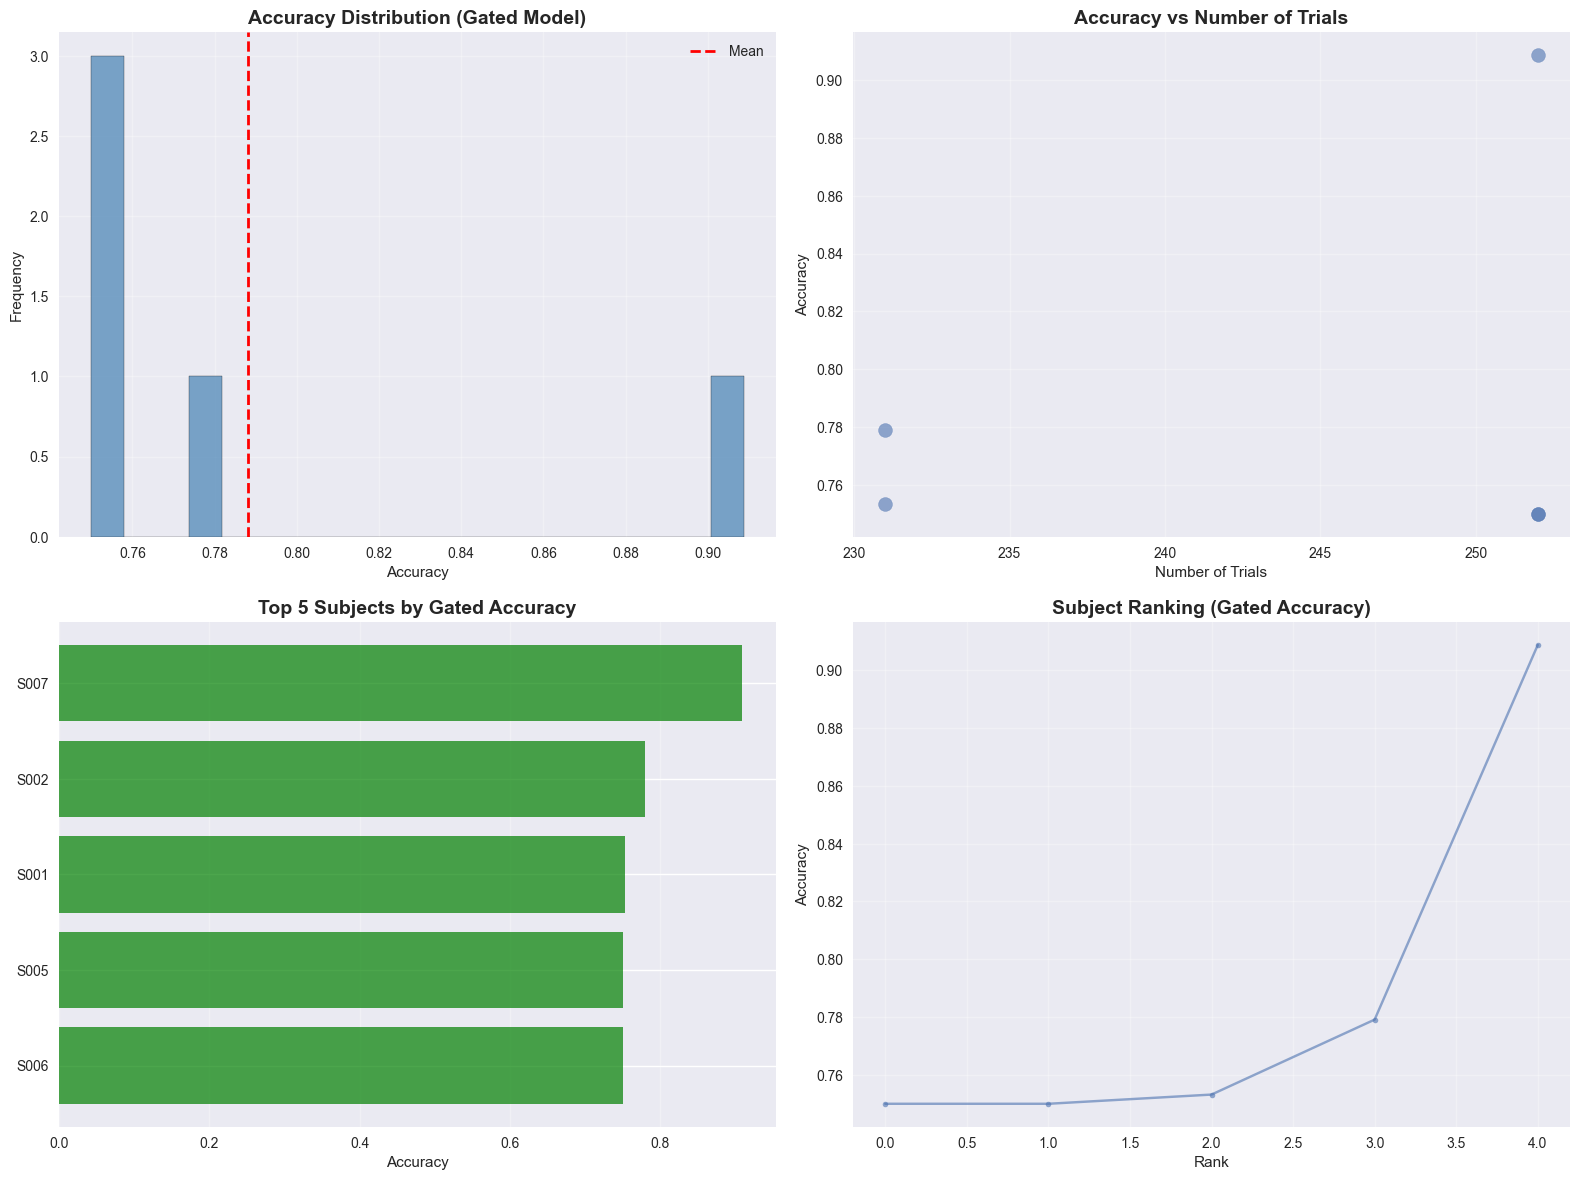

Visualizations saved to: results\trial4_gated_results_summary.png


In [12]:

if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    axes[0, 0].hist(results_df['gated_acc'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(results_df['gated_acc'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].set_title('Accuracy Distribution (Gated Model)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(results_df['num_trials'], results_df['gated_acc'], alpha=0.6, s=100)
    axes[0, 1].set_title('Accuracy vs Number of Trials', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Trials')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)

    top_10 = results_df.nlargest(min(10, len(results_df)), 'gated_acc')
    axes[1, 0].barh(range(len(top_10)), top_10['gated_acc'], color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10['subject'])
    axes[1, 0].set_title(f'Top {len(top_10)} Subjects by Gated Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    sorted_results = results_df.sort_values('gated_acc')
    axes[1, 1].plot(range(len(sorted_results)), sorted_results['gated_acc'], marker='o', markersize=4, alpha=0.6)
    axes[1, 1].set_title('Subject Ranking (Gated Accuracy)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    summary_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['results_summary_figure']
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualizations saved to: {summary_path}")
else:
    print('No results to visualize. Please ensure subjects were successfully trained.')


## Visualize Learned Adjacency Matrix (Example Subject)

Visualizing adjacency matrix for best subject: S007
Accuracy: 0.9087


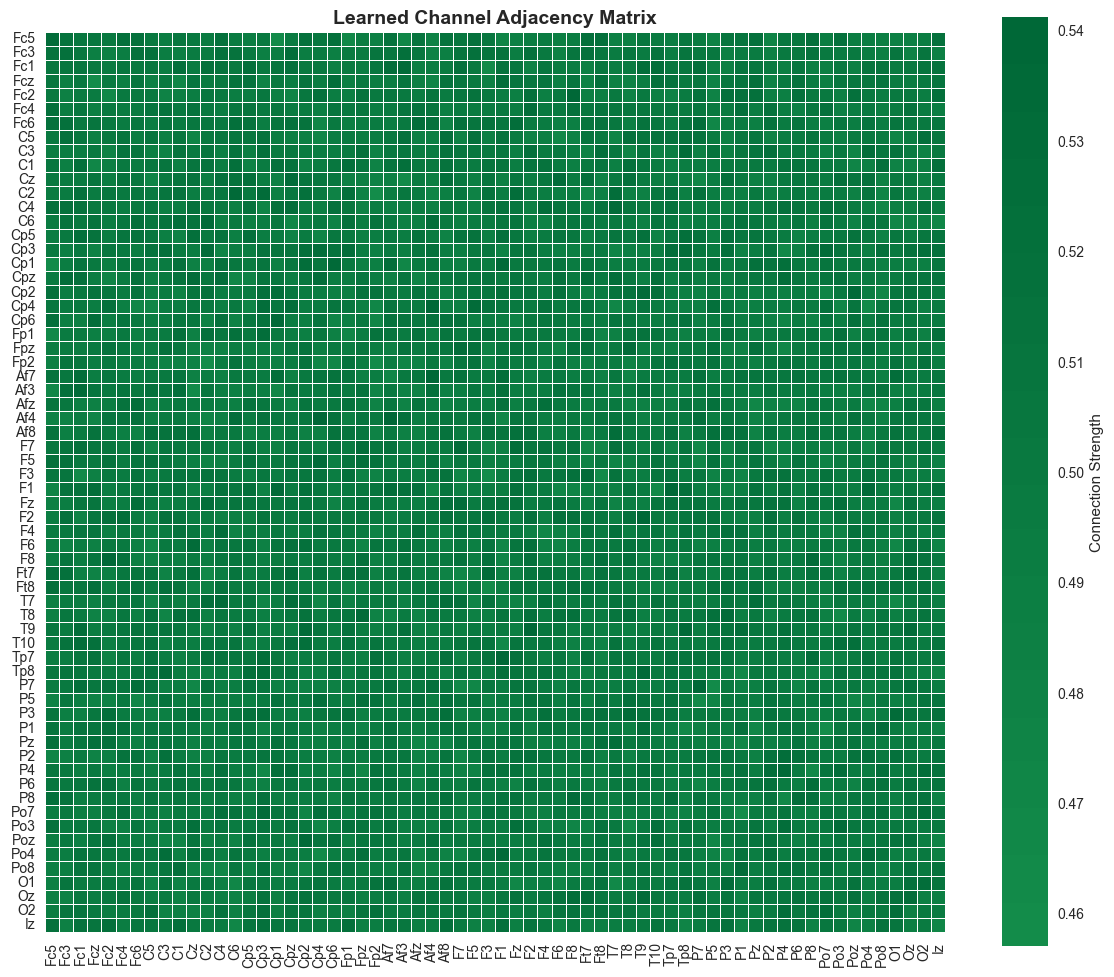

Adjacency figure saved to: results\trial4_adjacency_S007.png
Top 10 Edges (Edge Selection):
Selected channels: ['Fc2', 'Cp1', 'Cp2', 'Cp4', 'Cp6', 'Af7', 'Af4', 'F1', 'F2', 'F8', 'T9', 'Tp7', 'Tp8', 'Poz', 'Po4']
Top 10 Channels (Aggregation Selection):
Selected channels: ['Fc1', 'Fc4', 'Fc6', 'Cpz', 'Af7', 'F1', 'Fz', 'F2', 'T9', 'Oz']


In [13]:

if len(all_results) > 0:
    best_idx = results_df['gated_acc'].idxmax()
    best_result = all_results[best_idx]

    print(f"Visualizing adjacency matrix for best subject: {best_result['subject']}")
    print(f"Accuracy: {best_result['gated_acc']:.4f}")

    selector = ChannelSelector(best_result['adjacency_matrix'], best_result['channel_names'])

    adj_path = EXPERIMENT_CONFIG['output']['results_dir'] / f"{EXPERIMENT_CONFIG['output']['adjacency_prefix']}_{best_result['subject']}.png"
    fig = selector.visualize_adjacency(save_path=adj_path)
    plt.show()

    print(f"Adjacency figure saved to: {adj_path}")

    print("Top 10 Edges (Edge Selection):")
    selected_channels_es, _ = selector.edge_selection(10)
    print(f"Selected channels: {selected_channels_es}")

    print("Top 10 Channels (Aggregation Selection):")
    selected_channels_as, _ = selector.aggregation_selection(10)
    print(f"Selected channels: {selected_channels_as}")
else:
    print('No results available for adjacency visualization.')


## Export Results

In [14]:

if len(results_df) > 0:
    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['gated_results_file']
    results_df[['subject', 'num_trials', 'num_channels', 'gated_acc', 'gated_std', 'gate_mean', 'gate_std', 'gate_min', 'gate_max']].to_csv(results_path, index=False)

    if len(channel_selection_df) > 0:
        channel_selection_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['channel_selection_results_file']
        channel_selection_df.to_csv(channel_selection_path, index=False)
    else:
        channel_selection_path = None

    config_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'experiment_config_trial4_gated.json'
    with open(config_path, 'w') as f:
        json.dump(EXPERIMENT_CONFIG, f, indent=2, default=str)

    print('All results exported successfully!')
    print(f'  - Subject results: {results_path}')
    if channel_selection_path:
        print(f'  - Channel selection: {channel_selection_path}')
    print(f'  - Config: {config_path}')
else:
    print('No results to export.')


All results exported successfully!
  - Subject results: results\trial4_gated_subject_results.csv
  - Channel selection: results\trial4_channel_selection_results.csv
  - Config: results\experiment_config_trial4_gated.json


## Baseline Comparison

Compare gated trial results with the baseline EEG-ARNN run from `physionet_training.ipynb`.

In [15]:

baseline_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['baseline_results_file']
comparison_path = EXPERIMENT_CONFIG['output']['results_dir'] / EXPERIMENT_CONFIG['output']['comparison_file']

if len(results_df) > 0:
    if baseline_path.exists():
        baseline_df = pd.read_csv(baseline_path)
        comparison_df = results_df.merge(
            baseline_df[['subject', 'all_channels_acc', 'all_channels_std']],
            on='subject',
            how='left'
        )
        comparison_df['accuracy_delta'] = comparison_df['gated_acc'] - comparison_df['all_channels_acc']
        comparison_df.rename(columns={
            'all_channels_acc': 'baseline_acc',
            'all_channels_std': 'baseline_std'
        }, inplace=True)

        display_columns = ['subject', 'baseline_acc', 'baseline_std', 'gated_acc', 'gated_std', 'accuracy_delta', 'gate_mean', 'gate_std']
        display(comparison_df[display_columns])

        comparison_df[display_columns].to_csv(comparison_path, index=False)
        print(f"Baseline comparison saved to: {comparison_path}")
    else:
        print(f"Baseline results not found at {baseline_path}. Run physionet_training.ipynb first.")
else:
    print('No gated results available to compare against baseline.')


,subject,baseline_acc,baseline_std,gated_acc,gated_std,accuracy_delta,gate_mean,gate_std
0,S001,0.684370,0.089543,0.753186,0.014055,0.068816,0.899962,0.000399
1,S002,0.692504,0.031634,0.779123,0.022601,0.086619,0.899903,0.000344
2,S005,0.650794,0.023810,0.750000,0.011905,0.099206,0.900008,0.000612
3,S006,0.690476,0.023810,0.750000,0.003968,0.059524,0.899902,0.000293
4,S007,0.912698,0.000000,0.908730,0.003968,-0.003968,0.899950,0.000409


Baseline comparison saved to: results\trial4_gated_vs_baseline.csv
